In [ ]:
# meteonet north-west france


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("katerpillar/meteonet")

print("Path to dataset files:", path)

100%|██████████| 13.6G/13.6G [02:27<00:00, 99.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/katerpillar/meteonet/versions/25


In [ ]:
!pip install xarray netcdf4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.3 MB/s eta 0:00:00


In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
path = "/root/.cache/kagglehub/datasets/katerpillar/meteonet/versions/25/"
os.listdir(path)

['Satellite_WV062',
 'NW_rainfall_2018',
 'Satellite_IR039',
 'NW_reflectivity_old_product_2017',
 'NW_reflectivity_old_product_2018',
 'Satellite_IR108',
 'color_palettes',
 'Satellite_CT',
 'Masks',
 'NW_reflectivity_old_product_2016',
 'NW_Ground_Stations',
 'NW_weather_models_2D_parameters_201602',
 'Radar_coords',
 'NW_rainfall_2016',
 'Satellite_VIS06',
 'NW_rainfall_2017']

In [ ]:
satellite_ct_path = os.path.join(path,'Satellite_CT')
satellite_ct_path
os.listdir(satellite_ct_path)
satellite_ct_path = os.path.join(satellite_ct_path,'Satellite_CT')
satellite_ct_path


'/root/.cache/kagglehub/datasets/katerpillar/meteonet/versions/25/Satellite_CT/Satellite_CT'

In [ ]:
import xarray as xr

nc_files = [f for f in os.listdir(satellite_ct_path) if f.endswith('.nc')]

print(nc_files)

['CT_NW_2018.nc', 'CT_NW_2017.nc', 'CT_NW_2016.nc']


In [ ]:
file_path = os.path.join(satellite_ct_path,nc_files[0])
ds = xr.open_dataset(file_path)

print(ds)

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 34854, lat: 188, lon: 261)
Coordinates:
  * time     (time) datetime64[ns] 279kB 2018-01-01 ... 2018-12-31T23:45:00
  * lat      (lat) float64 2kB 51.9 51.87 51.84 51.81 ... 46.31 46.28 46.25
  * lon      (lon) float64 2kB -5.842 -5.812 -5.782 -5.752 ... 1.94 1.97 2.0
Data variables:
    CT       (time, lat, lon) uint8 2GB ...
Attributes:
    creating_function:   create_nc_file
    appending_function:  append_unlimited_dim_nc_file


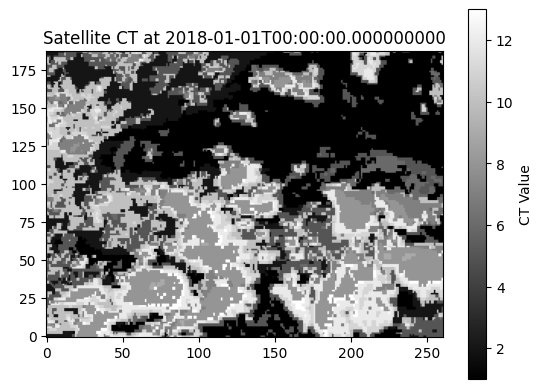

In [ ]:
import matplotlib.pyplot as plt

# Select first timestep
ct_slice = ds['CT'].isel(time=0)

plt.imshow(ct_slice, origin='lower', cmap='gray')  # Or another colormap
plt.colorbar(label='CT Value')
plt.title(f"Satellite CT at {ds['time'][0].values}")
plt.show()

In [ ]:
# these are the cloud top values from the satellite

ct_array = ds['CT'].values  # shape: (34854, 188, 261)
print(ct_array.shape, ct_array.dtype)

(34854, 188, 261) uint8


In [ ]:
import os
dataset_path = "/root/.cache/kagglehub/datasets/katerpillar/meteonet/versions/25/"
satellite_ct_path = os.path.join(dataset_path, "Satellite_CT")
satellite_ct_path
os.listdir(satellite_ct_path)
satellite_ct_path = os.path.join(satellite_ct_path,'Satellite_CT')
# print("\n[1] Loading satellite data...")

nc_files = [f for f in os.listdir(satellite_ct_path) if f.endswith('.nc')]
print(f"Found files: {nc_files}")

Found files: ['CT_NW_2018.nc', 'CT_NW_2017.nc', 'CT_NW_2016.nc']


In [ ]:
import numpy as np
import xarray as xr
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import gc

print("=" * 60)
print("ROBUST SATELLITE CLOUD PREDICTION")
print("=" * 60)

# --------------------------------------------------
# Dataset path
# --------------------------------------------------
dataset_path = "/root/.cache/kagglehub/datasets/katerpillar/meteonet/versions/25/"
satellite_ct_path = os.path.join(dataset_path, "Satellite_CT", "Satellite_CT")

print(f"Dataset path: {satellite_ct_path}")

print("\n[1] Loading satellite data (trying different files)...")

nc_files = sorted([f for f in os.listdir(satellite_ct_path) if f.endswith('.nc')])
print(f"Found files: {nc_files}")

# Try loading different files in case one is corrupted
ds = None
loaded_file = None

for nc_file in nc_files:
    file_path = os.path.join(satellite_ct_path, nc_file)
    print(f"\nTrying to load: {nc_file}")

    try:
        # Try method 1: xarray with engine specified
        print("  Attempt 1: xarray with netcdf4 engine...")
        ds = xr.open_dataset(
            file_path,
            engine='netcdf4',
            chunks={'time': 500}
        )
        loaded_file = nc_file
        print(f"  ✓ Successfully loaded {nc_file}!")
        break
    except Exception as e:
        print(f"  ✗ Failed with netcdf4: {str(e)[:100]}")

        try:
            # Try method 2: xarray with h5netcdf engine (more robust)
            print("  Attempt 2: xarray with h5netcdf engine...")
            ds = xr.open_dataset(
                file_path,
                engine='h5netcdf',
                chunks={'time': 500}
            )
            loaded_file = nc_file
            print(f"  ✓ Successfully loaded {nc_file} with h5netcdf!")
            break
        except Exception as e2:
            print(f"  ✗ Failed with h5netcdf: {str(e2)[:100]}")

            try:
                # Try method 3: Load without chunking
                print("  Attempt 3: xarray without chunking...")
                ds = xr.open_dataset(file_path)
                loaded_file = nc_file
                print(f"  ✓ Successfully loaded {nc_file} without chunking!")
                break
            except Exception as e3:
                print(f"  ✗ Failed without chunking: {str(e3)[:100]}")
                print(f"  Skipping {nc_file}, trying next file...")
                continue

if ds is None:
    print("\n❌ ERROR: Could not load any NetCDF file!")
    print("\nTrying alternative: Loading with netCDF4 library directly...")

    import netCDF4 as nc

    for nc_file in nc_files:
        file_path = os.path.join(satellite_ct_path, nc_file)
        try:
            print(f"Trying {nc_file} with netCDF4...")
            ncfile = nc.Dataset(file_path, 'r')
            ct_data_raw = ncfile.variables['CT'][:]
            ncfile.close()

            print(f"✓ Loaded directly with netCDF4: {ct_data_raw.shape}")
            loaded_file = nc_file

            # Convert to numpy array
            ct_data = np.array(ct_data_raw)
            break
        except Exception as e:
            print(f"Failed: {str(e)[:100]}")
            continue

    if 'ct_data' not in locals():
        raise RuntimeError("Could not load any file. Dataset may be corrupted.")
else:
    print(f"\n✓ Dataset loaded: {loaded_file}")
    print(f"  Time steps: {ds.dims['time']}")
    print(f"  Lat: {ds.dims['lat']}")
    print(f"  Lon: {ds.dims['lon']}")

    print("\n[2] Processing data in memory-efficient chunks...")

    # Use subset
    N_use = 2000  # Using 2000 timesteps
    print(f"Using first {N_use} timesteps")

    # Downsample spatial resolution
    target_height, target_width = 94, 130

    ct_data_list = []
    chunk_size = 400  # Smaller chunks

    for i in range(0, N_use, chunk_size):
        end_idx = min(i + chunk_size, N_use)
        print(f"  Processing timesteps {i} to {end_idx}...")

        try:
            # Load chunk
            chunk = ds['CT'].isel(time=slice(i, end_idx)).values

            # Downsample
            chunk_downsampled = chunk[:, ::2, ::2]

            ct_data_list.append(chunk_downsampled)

            del chunk
            gc.collect()
        except Exception as e:
            print(f"  Warning: Failed to load chunk {i}-{end_idx}: {e}")
            continue

    if not ct_data_list:
        raise RuntimeError("No data chunks loaded successfully")

    # Combine chunks
    ct_data = np.concatenate(ct_data_list, axis=0)
    del ct_data_list
    gc.collect()

    # Close dataset
    ds.close()
    del ds
    gc.collect()

print(f"\n✓ Final data shape: {ct_data.shape}")
print(f"  Memory usage: {ct_data.nbytes / 1024**2:.2f} MB")

print("\n[3] Preprocessing...")

# Convert to float16
ct_data = ct_data.astype(np.float16)
ct_data = np.nan_to_num(ct_data, nan=0.0)

n_timesteps, height, width = ct_data.shape
n_features = height * width

print(f"  Shape: ({n_timesteps}, {height}, {width})")
print(f"  Features: {n_features:,}")

# Normalize
print("Normalizing...")
sample_for_fit = ct_data[:300].reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(sample_for_fit)
del sample_for_fit
gc.collect()

# Transform in chunks
chunk_size = 400
X_data = np.zeros((n_timesteps, n_features), dtype=np.float16)

for i in range(0, n_timesteps, chunk_size):
    end_idx = min(i + chunk_size, n_timesteps)
    chunk = ct_data[i:end_idx].reshape(-1, 1)
    X_data[i:end_idx] = scaler.transform(chunk).reshape(end_idx - i, n_features).astype(np.float16)
    del chunk
    gc.collect()

del ct_data
gc.collect()

print(f"✓ Normalized: {X_data.shape}")

print("\n[4] Creating sequences...")

lookback = 6  # Reduced to 6

X_seq = []
y_seq = []

for i in range(len(X_data) - lookback - 1):
    X_seq.append(X_data[i:i+lookback])
    y_seq.append(X_data[i+lookback])

    if i % 300 == 0:
        print(f"  {i}/{len(X_data) - lookback - 1}")

X_seq = np.array(X_seq, dtype=np.float16)
y_seq = np.array(y_seq, dtype=np.float16)

del X_data
gc.collect()

print(f"✓ Sequences: {X_seq.shape}")

split_idx = int(0.8 * len(X_seq))
X_train = X_seq[:split_idx].astype(np.float32)
y_train = y_seq[:split_idx].astype(np.float32)
X_val = X_seq[split_idx:].astype(np.float32)
y_val = y_seq[split_idx:].astype(np.float32)

del X_seq, y_seq
gc.collect()

print(f"\n✓ Train: {X_train.shape[0]}")
print(f"✓ Val: {X_val.shape[0]}")

print("\n[5] Building model...")

model = keras.Sequential([
    layers.Input(shape=(lookback, n_features)),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.LSTM(32),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(n_features)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()

print("\n[6] Training...")

history = model.fit(
    X_train, y_train,
    batch_size=8,  # Very small batch
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
    ],
    verbose=1
)

del X_train, y_train
gc.collect()

print("\n[7] Making predictions...")

preds = model.predict(X_val[:15], batch_size=3)

def reshape_spatial(data):
    return data.reshape(-1, height, width)

pred_spatial = reshape_spatial(preds)
true_spatial = reshape_spatial(y_val[:15])

print("\n[8] Creating visualizations...")

# Training
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training History')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Val')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE')
plt.grid(True)

plt.tight_layout()
plt.savefig('training.png', dpi=100)
print("✓ Saved: training.png")
plt.close()

# Predictions
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

for i in range(3):
    axes[i, 0].imshow(true_spatial[i], cmap='viridis')
    axes[i, 0].set_title('True')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(pred_spatial[i], cmap='viridis')
    axes[i, 1].set_title('Predicted')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(np.abs(true_spatial[i] - pred_spatial[i]), cmap='Reds')
    axes[i, 2].set_title('Error')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('predictions.png', dpi=100)
print("✓ Saved: predictions.png")
plt.close()

# Forecast
def forecast(seq, steps=4):
    preds = []
    curr = seq.copy()
    for _ in range(steps):
        p = model.predict(curr[np.newaxis, ...], batch_size=1, verbose=0)[0]
        preds.append(p)
        curr = np.vstack([curr[1:], p])
    return np.array(preds)

future = forecast(X_val[0], steps=4)
future_spatial = reshape_spatial(future)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for t in range(4):
    axes[t].imshow(future_spatial[t], cmap='viridis')
    axes[t].set_title(f't+{t+1}')
    axes[t].axis('off')

plt.tight_layout()
plt.savefig('forecast.png', dpi=100)
print("✓ Saved: forecast.png")
plt.close()

print("\n[9] Saving...")

model.save('model.keras')
print("✓ Model: model.keras")

import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('metadata.pkl', 'wb') as f:
    pickle.dump({
        'lookback': lookback,
        'shape': (height, width),
        'features': n_features,
        'file': loaded_file
    }, f)

print("✓ Scaler and metadata saved")

print("\n" + "=" * 60)
print("✅ COMPLETE!")
print("=" * 60)
print(f"Loaded file: {loaded_file}")
print(f"Val loss: {history.history['val_loss'][-1]:.6f}")
print(f"Val MAE: {history.history['val_mae'][-1]:.6f}")
print("\nOutputs:")
print("  • training.png")
print("  • predictions.png")
print("  • forecast.png")
print("  • model.keras")
print("=" * 60)

ROBUST SATELLITE CLOUD PREDICTION
Dataset path: /root/.cache/kagglehub/datasets/katerpillar/meteonet/versions/25/Satellite_CT/Satellite_CT

[1] Loading satellite data (trying different files)...
Found files: ['CT_NW_2016.nc', 'CT_NW_2017.nc', 'CT_NW_2018.nc']

Trying to load: CT_NW_2016.nc
  Attempt 1: xarray with netcdf4 engine...
  ✗ Failed with netcdf4: [Errno -101] NetCDF: HDF error: '/root/.cache/kagglehub/datasets/katerpillar/meteonet/versions/25/Sa
  Attempt 2: xarray with h5netcdf engine...
  ✓ Successfully loaded CT_NW_2016.nc with h5netcdf!

✓ Dataset loaded: CT_NW_2016.nc
  Time steps: 34880
  Lat: 188
  Lon: 261

[2] Processing data in memory-efficient chunks...
Using first 2000 timesteps
  Processing timesteps 0 to 400...
  Processing timesteps 400 to 800...


/tmp/ipython-input-859679560.py:107: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"  Time steps: {ds.dims['time']}")
/tmp/ipython-input-859679560.py:108: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"  Lat: {ds.dims['lat']}")
/tmp/ipython-input-859679560.py:109: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"  Lon: {ds.dims['lon']}")


  Processing timesteps 800 to 1200...
  Processing timesteps 1200 to 1600...
  Processing timesteps 1600 to 2000...

✓ Final data shape: (2000, 94, 131)
  Memory usage: 23.49 MB

[3] Preprocessing...
  Shape: (2000, 94, 131)
  Features: 12,314
Normalizing...
✓ Normalized: (2000, 12314)

[4] Creating sequences...
  0/1993
  300/1993
  600/1993
  900/1993
  1200/1993
  1500/1993
  1800/1993
✓ Sequences: (1993, 6, 12314)

✓ Train: 1594
✓ Val: 399

[5] Building model...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 6, 64)          │     3,169,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 12314)          │       800,410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,346 (15.20 MB)

 Trainable params: 3,984,154 (15.20 MB)

 Non-trainable params: 192 (768.00 B)


[6] Training...
Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - loss: 1.0955 - mae: 0.8504 - val_loss: 1.0777 - val_mae: 0.8649 - learning_rate: 0.0010
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - loss: 0.9421 - mae: 0.7895 - val_loss: 1.0024 - val_mae: 0.8462 - learning_rate: 0.0010
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - loss: 0.9037 - mae: 0.7704 - val_loss: 0.9898 - val_mae: 0.8346 - learning_rate: 0.0010
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - loss: 0.8932 - mae: 0.7652 - val_loss: 0.9737 - val_mae: 0.8263 - learning_rate: 0.0010
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - loss: 0.9025 - mae: 0.7748 - val_loss: 0.9516 - val_mae: 0.8156 - learning_rate: 0.0010
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - loss: 0.8779 - mae: 0.7592 - val_loss: 0.9677 - val_mae: 0.8320 - learning_rate: 0.0010
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - loss: 0.8668 - mae: 0.7533 - val_loss: 0.9548 - val_mae:

In [ ]:
path = "/root/.cache/kagglehub/datasets/katerpillar/meteonet/versions/25/"
os.listdir(path)

['Satellite_WV062',
 'NW_rainfall_2018',
 'Satellite_IR039',
 'NW_reflectivity_old_product_2017',
 'NW_reflectivity_old_product_2018',
 'Satellite_IR108',
 'color_palettes',
 'Satellite_CT',
 'Masks',
 'NW_reflectivity_old_product_2016',
 'NW_Ground_Stations',
 'NW_weather_models_2D_parameters_201602',
 'Radar_coords',
 'NW_rainfall_2016',
 'Satellite_VIS06',
 'NW_rainfall_2017']

In [ ]:
# satellite part is done , so now i will code for the rainfall part

rainfall_path = os.path.join(path,'NW_rainfall_2018')
rainfall_path

os.listdir(rainfall_path)

rainfall_path_2018 = os.path.join(rainfall_path,'NW_rainfall_2018')
rainfall_path_2018

rainfall_path_2018 = os.listdir(rainfall_path_2018)

['rainfall-NW-2018-06',
 'rainfall-NW-2018-08',
 'rainfall-NW-2018-05',
 'rainfall-NW-2018-12',
 'rainfall-NW-2018-10',
 'rainfall-NW-2018-03',
 'rainfall-NW-2018-04',
 'rainfall-NW-2018-07',
 'rainfall-NW-2018-09',
 'rainfall-NW-2018-11',
 'rainfall-NW-2018-02',
 'rainfall-NW-2018-01']

In [ ]:
rainfall_path_2018_jan = os.path.join(rainfall_path_2018,'rainfall-NW-2018-01')
rainfall_path_2018_jan

os.listdir(rainfall_path_2018_jan)

rainfall_path_2018_jan = os.path.join(rainfall_path_2018_jan,'rainfall-NW-2018-01')
rainfall_path_2018_jan

os.listdir(rainfall_path_2018_jan)

npz_files = [f for f in os.listdir(rainfall_path_2018_jan) if f.endswith('.npz')]
print(npz_files)

['rainfall_NW_2018_01.1.npz', 'rainfall_NW_2018_01.2.npz', 'rainfall_NW_2018_01.3.npz']


In [ ]:
rainfall_file = os.path.join(
    rainfall_path_2018_jan,
    'rainfall_NW_2018_01.1.npz'
)

data = np.load(rainfall_file)
print(data.files)

['data', 'dates', 'miss_dates']


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

path = "/root/.cache/kagglehub/datasets/katerpillar/meteonet/versions/25/"
rainfall_path_2018_jan = os.path.join(rainfall_path_2018,'rainfall-NW-2018-01')
rainfall_path_2018_jan = os.path.join(rainfall_path_2018_jan,'rainfall-NW-2018-01')
# npz_files = [f for f in os.listdir(rainfall_path_2018_jan) if f.endswith('.npz')]
# rainfall_file = os.path.join(
#     rainfall_path_2018_jan,
#     'rainfall_NW_2018_01.1.npz'
# )

# data = np.load(rainfall_file)

files = [f for f in os.listdir(rainfall_path_2018_jan) if f.endswith(".npz")]

print(f"files are {files}")
rain_list = []

for f in files:
    d = np.load(os.path.join(rainfall_path_2018_jan, f))
    rain_list.append(d["data"])

rainfall = np.concatenate(rain_list, axis=0).astype("float32")

labels = (rainfall >= 1.0).astype("float32")

rainfall = rainfall[..., np.newaxis]
labels = labels[..., np.newaxis]

N = rainfall.shape[0]
split = int(0.8 * N)

X_train = rainfall[:split]
y_train = labels[:split]
X_val = rainfall[split:]
y_val = labels[split:]

print(f"Data is splitted")

model = models.Sequential([
    layers.Input(shape=X_train.shape[1:]),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.Conv2D(1, 1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=8)

pred = model.predict(X_val[:1])[0, :, :, 0]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(X_val[0, :, :, 0], cmap="Blues")
plt.title("Rainfall")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(y_val[0, :, :, 0], cmap="gray")
plt.title("True Detection")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred > 0.5, cmap="gray")
plt.title("Predicted Detection")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# path = "/root/.cache/kagglehub/datasets/katerpillar/meteonet/versions/25/"

# rainfall_path_2018 = os.path.join(path, "NW_rainfall_2018")
# rainfall_path_2018_jan = os.path.join(rainfall_path_2018, "rainfall-NW-2018-01")

# files = [f for f in os.listdir(rainfall_path_2018_jan) if f.endswith(".npz")]
# print("Files:", files)
path = "/root/.cache/kagglehub/datasets/katerpillar/meteonet/versions/25"

rainfall_path_2018_jan = os.path.join(
    path,
    "NW_rainfall_2018",
    "NW_rainfall_2018",
    "rainfall-NW-2018-01",
    "rainfall-NW-2018-01"
)

files = [f for f in os.listdir(rainfall_path_2018_jan) if f.endswith(".npz")]
print(files)

rain_list = []

for f in files:
    d = np.load(os.path.join(rainfall_path_2018_jan, f))
    rain_list.append(d["data"])

rainfall = np.concatenate(rain_list, axis=0).astype("float32")

labels = (rainfall >= 1.0).astype("float32")

rainfall = rainfall[..., np.newaxis]
labels = labels[..., np.newaxis]

N = rainfall.shape[0]
split = int(0.8 * N)

X_train = rainfall[:split]
y_train = labels[:split]
X_val = rainfall[split:]
y_val = labels[split:]

print("Data split complete")

model = models.Sequential([
    layers.Input(shape=X_train.shape[1:]),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.Conv2D(1, 1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=8
)

pred = model.predict(X_val[:1])[0, :, :, 0]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(X_val[0, :, :, 0], cmap="Blues")
plt.title("Rainfall")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(y_val[0, :, :, 0], cmap="gray")
plt.title("True Detection")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred > 0.5, cmap="gray")
plt.title("Predicted Detection")
plt.axis("off")

plt.tight_layout()
plt.show()

['rainfall_NW_2018_01.1.npz', 'rainfall_NW_2018_01.2.npz', 'rainfall_NW_2018_01.3.npz']


Files: ['rainfall_NW_2018_01.1.npz', 'rainfall_NW_2018_01.2.npz', 'rainfall_NW_2018_01.3.npz']
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 266ms/step - accuracy: 0.9436 - loss: 0.5649
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 260ms/step - accuracy: 0.9934 - loss: 0.1705
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 264ms/step - accuracy: 0.9972 - loss: 0.0258
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 272ms/step - accuracy: 0.9980 - loss: 0.0093
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - accuracy: 0.9990 - loss: 0.0068
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


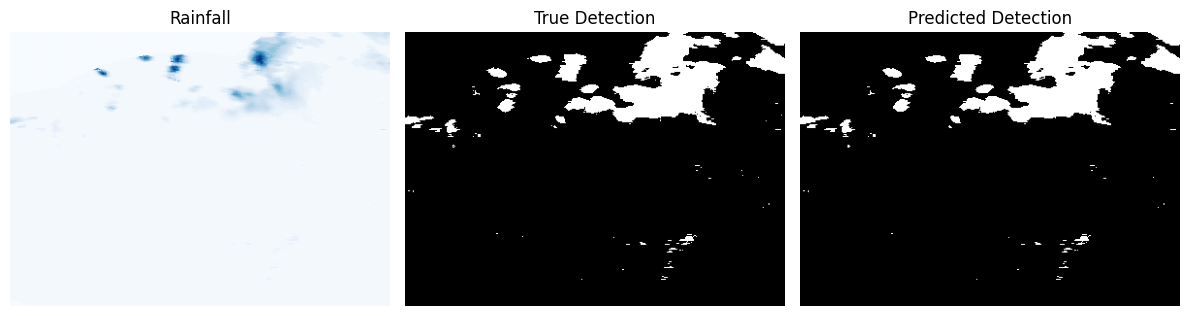

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

path = "/root/.cache/kagglehub/datasets/katerpillar/meteonet/versions/25"

rainfall_path_2018_jan = os.path.join(
    path,
    "NW_rainfall_2018",
    "NW_rainfall_2018",
    "rainfall-NW-2018-01",
    "rainfall-NW-2018-01"
)

files = [f for f in os.listdir(rainfall_path_2018_jan) if f.endswith(".npz")]
print("Files:", files)

def rainfall_generator(files, batch_size=2):
    while True:
        for f in files:
            d = np.load(os.path.join(rainfall_path_2018_jan, f))
            data = d["data"].astype("float16")

            data = data[:, ::2, ::2]
            labels = (data >= 1.0).astype("float16")

            data = data[..., np.newaxis]
            labels = labels[..., np.newaxis]

            for i in range(0, data.shape[0], batch_size):
                yield data[i:i+batch_size], labels[i:i+batch_size]

sample = np.load(os.path.join(rainfall_path_2018_jan, files[0]))["data"]
sample = sample[:, ::2, ::2]
H, W = sample.shape[1], sample.shape[2]

model = models.Sequential([
    layers.Input(shape=(H, W, 1)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.Conv2D(1, 1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

train_gen = rainfall_generator(files, batch_size=2)

model.fit(
    train_gen,
    steps_per_epoch=50,
    epochs=5
)

X_vis, y_vis = next(train_gen)
pred = model.predict(X_vis[:1])[0, :, :, 0]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(X_vis[0, :, :, 0], cmap="Blues")
plt.title("Rainfall")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(y_vis[0, :, :, 0], cmap="gray")
plt.title("True Detection")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred > 0.5, cmap="gray")
plt.title("Predicted Detection")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
path = "/root/.cache/kagglehub/datasets/katerpillar/meteonet/versions/25/"
os.listdir(path)

['Satellite_WV062',
 'NW_rainfall_2018',
 'Satellite_IR039',
 'NW_reflectivity_old_product_2017',
 'NW_reflectivity_old_product_2018',
 'Satellite_IR108',
 'color_palettes',
 'Satellite_CT',
 'Masks',
 'NW_reflectivity_old_product_2016',
 'NW_Ground_Stations',
 'NW_weather_models_2D_parameters_201602',
 'Radar_coords',
 'NW_rainfall_2016',
 'Satellite_VIS06',
 'NW_rainfall_2017']